In [1]:
import tensorflow as tf
import keras
from draw_candle_image import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta.trend
from ta import add_all_ta_features
from ta.utils import dropna
import ta
import ta.momentum
import json
from common_train_utils import *
from functools import partial
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import pathlib
import shutil
import tempfile
import tensorflow_docs.modeling
from model_code import *
import os

In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
print(logdir)

C:\Users\ADMIN\AppData\Local\Temp\tmp5kk9aoqr\tensorboard_logs


In [4]:
dataset_folder = "./dataset/vn30_dataset_0_2_3_2012_2024_test_2023_2024"

In [5]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [6]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)

folder: bullish_engulfing, 		 total: 10 images
folder: bearish_engulfing, 		 total: 11 images
folder: star_doji, 		 total: 0 images
folder: dragonfly_doji, 		 total: 0 images
folder: gravestone_doji, 		 total: 0 images
folder: morning_star, 		 total: 13 images
folder: evening_star, 		 total: 0 images
folder: hammer, 		 total: 13 images
folder: inverted_hammer, 		 total: 15 images
folder: harami_down, 		 total: 30 images
folder: harami_up, 		 total: 40 images
folder: tweezer_top, 		 total: 0 images
folder: tweezer_bottom, 		 total: 6 images
folder: marubozu, 		 total: 19 images
folder: spin, 		 total: 7 images
folder: next_3_day_up, 		 total: 41 images
folder: next_3_day_down, 		 total: 31 images


In [7]:
dataset_train = load_dataset_of_each_type_and_combine(f"{dataset_folder}/train", candle_type_and_directory_save)
total_data_train = len(dataset_train)
batch_size = 100

folder: bullish_engulfing, 		 total: 27 images
folder: bearish_engulfing, 		 total: 32 images
folder: star_doji, 		 total: 9 images
folder: dragonfly_doji, 		 total: 9 images
folder: gravestone_doji, 		 total: 14 images
folder: morning_star, 		 total: 39 images
folder: evening_star, 		 total: 54 images
folder: hammer, 		 total: 46 images
folder: inverted_hammer, 		 total: 71 images
folder: harami_down, 		 total: 170 images
folder: harami_up, 		 total: 164 images
folder: tweezer_top, 		 total: 47 images
folder: tweezer_bottom, 		 total: 35 images
folder: marubozu, 		 total: 124 images
folder: spin, 		 total: 54 images
folder: next_3_day_up, 		 total: 219 images
folder: next_3_day_down, 		 total: 166 images


In [8]:
(total_data_train, total_data_test)

(1280, 236)

In [9]:
for images_train, labels_train, dates_train in dataset_train.take(5):
    print(images_train.shape)
    print(labels_train.shape)

(287, 287, 3)
(6, 4)
(287, 287, 3)
(6, 4)
(287, 287, 3)
(6, 4)
(287, 287, 3)
(6, 4)
(287, 287, 3)
(6, 4)


In [10]:
image_shape = tuple(images_train.shape)

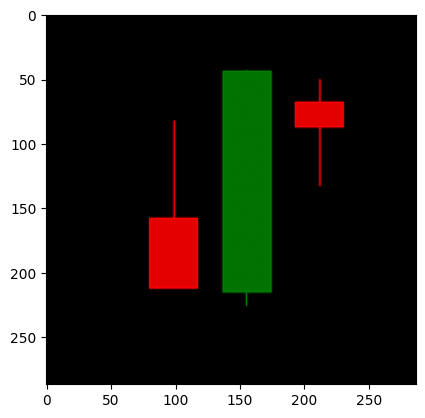

In [11]:
plt.imshow(images_train)

In [12]:
dataset_train_1 = dataset_train.shuffle(300)
dataset_test_1 = dataset_test.shuffle(300)

In [13]:
(len(dataset_train_1), len(dataset_test_1))

(1280, 236)

In [14]:
dataset_train_2 = dataset_train_1.batch(batch_size)
dataset_test_2 = dataset_test_1.batch(batch_size)

In [15]:
transform_function = partial(get_open_close_prices_percent_of_last_days_result, days_result)
dataset_train_3 = dataset_train_2.map(transform_function)
dataset_test_3 = dataset_test_2.map(transform_function)

In [16]:
(len(dataset_train_3), len(dataset_test_3))

(13, 3)

In [17]:
dataset_train_3

<_MapDataset element_spec=(TensorSpec(shape=(None, 287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3, 2), dtype=tf.float64, name=None))>

In [18]:
dataset_test_3

<_MapDataset element_spec=(TensorSpec(shape=(None, 287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3, 2), dtype=tf.float64, name=None))>

In [19]:
def model_5(image_shape, days_result):
    model = keras.Sequential([
        keras.layers.Input(image_shape),
        # keras.layers.Conv2D(32, (2, 2), activation='relu'),
        # keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        # keras.layers.Conv2D(8, (3, 3), activation='relu'),
        # keras.layers.MaxPooling2D((4, 4)),
        keras.layers.Flatten(),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.1),  # Giảm tỷ lệ Dropout
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.RepeatVector(days_result),
        keras.layers.LSTM(64, activation='tanh', return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(2))
    ])
    
    return model, "model_5"

In [20]:
model, model_name = model_5(image_shape, days_result)

In [21]:
model_name

'model_5'

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 247107)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     7,907,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 2)           │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,933,474 (30.26 MB)

 Trainable params: 7,933,474 (30.26 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
STEPS_PER_EPOCH = total_data_train // batch_size + 1
name_sub_folder_save_metrics = f"{model_name}_{dataset_folder}"
name_folder_save_metrics = f"sizes/{model_name}_{dataset_folder}"
max_epochs = 200

In [24]:
STEPS_PER_EPOCH

13

In [25]:
lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
    0.01,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=1,
    staircase=False
)


def get_optimizer():
    return keras.optimizers.Adam(lr_schedule)


def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=20),
        keras.callbacks.TensorBoard(logdir/name)
    ]


In [26]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(),
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
    ],
)

In [27]:
history = model.fit(
    dataset_train_3, 
    validation_data=dataset_test_3,
    epochs=max_epochs, 
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=get_callbacks(name_folder_save_metrics)
)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 1.2961 - mean_absolute_error: 0.7706
Epoch: 0, loss:1.2993,  mean_absolute_error:0.7619,  val_loss:0.8091,  val_mean_absolute_error:0.6121,  
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - loss: 1.2963 - mean_absolute_error: 0.7700 - val_loss: 0.8091 - val_mean_absolute_error: 0.6121
Epoch 2/200


C:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00 - val_loss: 0.8091 - val_mean_absolute_error: 0.6121
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - loss: 1.2270 - mean_absolute_error: 0.7220 - val_loss: 0.7974 - val_mean_absolute_error: 0.5969
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00 - val_loss: 0.7974 - val_mean_absolute_error: 0.5969
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - loss: 1.1549 - mean_absolute_error: 0.7043 - val_loss: 0.7909 - val_mean_absolute_error: 0.5967
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00 - val_loss: 0.7909 - val_mean_absolute_error: 0.5967
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - loss: 1.1846 - mean_absolute_error: 0.7090 - val_loss: 0.8076 - val_mean_absolute_error: 0.6177
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0000e+00 - mean_absolut

In [28]:
def save_dataset(prefix, dataset_test, model_name):
    prefix_of_folder = prefix
    path_save = f"{dataset_folder}/{prefix_of_folder}_of_{model_name}"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        prefix_of_folder = prefix_of_folder + "_1"
        path_save = f"{dataset_folder}/{prefix_of_folder}_of_{model_name}"
        print(f"-- Change to {path_save}")
    
    print(f"Save to {path_save}")
    tf.data.Dataset.save(dataset_test, path_save)

In [29]:
def save_model(model: keras.Sequential, model_name):
    path_save = f"{dataset_folder}/model_save/{model_name}.keras"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        model_name = model_name + "_1"
        path_save = f"{dataset_folder}/model_save/{model_name}.keras"
        print(f"-- Change to {path_save}")
    
    print(f"Save to {path_save}")
    model.save(path_save)

In [30]:
save_model(model, model_name)

Save to ./dataset/vn30_dataset_0_2_3_2012_2024_test_2023_2024/model_save/model_5.keras


In [31]:
size_histories = {}

In [32]:
size_histories[name_sub_folder_save_metrics] = history 

(0.0, 2.0)

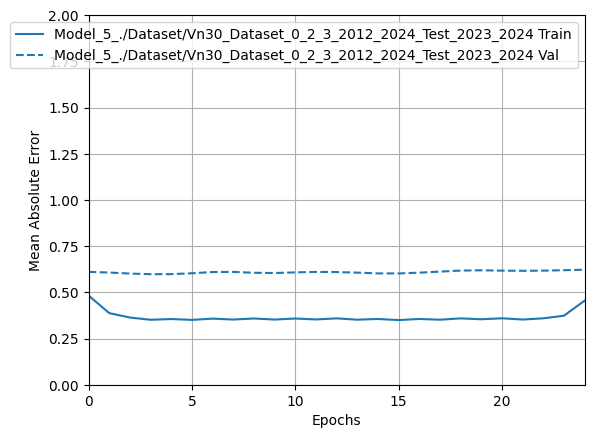

In [33]:
plotter = tfdocs.plots.HistoryPlotter(metric='mean_absolute_error', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0,2])

In [34]:
train_dataset = tf.data.Dataset.load(f'{dataset_folder}/train/next_3_day_up')
test_dataset = tf.data.Dataset.load(f'{dataset_folder}/test/next_3_day_up')

In [35]:
for x_train, y_train, date_train in train_dataset.take(2):
    pass
for x_test, y_test, date_test in test_dataset.take(2):
    pass

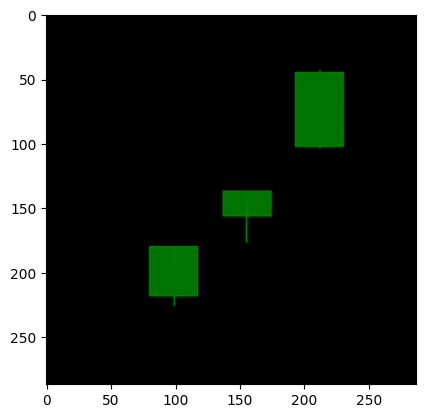

In [36]:
plt.imshow(x_train)

In [37]:
y_train

<tf.Tensor: shape=(6, 4), dtype=float64, numpy=
array([[483.19, 479.93, 485.18, 478.85],
       [488.36, 488.36, 491.01, 485.55],
       [503.74, 495.69, 503.54, 495.45],
       [538.98, 534.73, 508.41, 507.2 ],
       [506.49, 500.2 , 505.9 , 494.59],
       [503.39, 495.63, 489.05, 494.47]])>

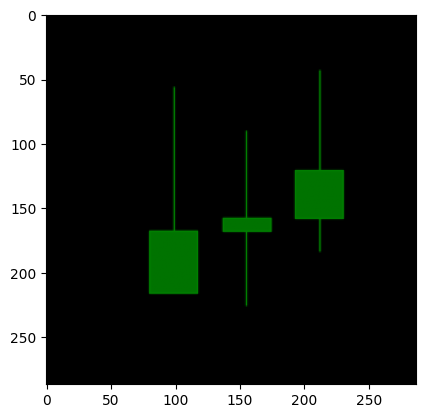

In [38]:
plt.imshow(x_test)

In [39]:
y_test

<tf.Tensor: shape=(6, 4), dtype=float64, numpy=
array([[1076.22, 1060.53, 1065.22, 1060.53],
       [1072.81, 1065.22, 1066.24, 1059.52],
       [1077.45, 1066.24, 1069.86, 1063.68],
       [1076.97, 1069.86, 1075.71, 1066.78],
       [1103.73, 1075.71, 1103.73, 1075.71],
       [1117.23, 1106.89, 1115.72, 1104.98]])>